Importing the required libraries.

In [44]:
import fenics as fe

In [45]:
import matplotlib.pyplot as plt

In [46]:
import numpy as np

In [47]:
%matplotlib inline

# Energy Equation

We need to solve the energy equation,
     
    𝜌(𝜕𝑡ℎ+𝑢∙∇ℎ)=𝑘∆T.
         
       where 𝜌 = density
                                                               
             𝜕𝑡ℎ = derivative of enthalpy with respect to temperature 
                                                       
             𝑢 = velocity of the fluid in consideration 
             
             h = Enthalpy of the substance
                                    
                                    

In [48]:
#Trial 4
#Defining the constants
Mesh_size=100     #Taking the mesh size to be 100
L=(1.01*c)      #The latent heat of fusion of ice. 
ste=fe.Constant(0.045)   #Stefan Number
prandl_number=fe.Constant(1)
rho=1     #Density
K=1       #thermal conductivity
c=1       #Specific heat of capacity
timestep_size = 1.e-2
Delta_t = fe.Constant(timestep_size)                   #Time difference to be taken as constant of 10e-2

 For the stefan problem, the following assumptions are made:
                                
                                * The specific heat capacity is constant.
                                * u.∇($\phi$) is small and neglected.
                                * Prandl number is taken to be one.
                                

                                     Writing it in weak form, here v is the test function
     
                                             (𝑣,𝜕𝑡ℎ)=−𝑑𝑇/𝑑ℎ(𝑘/𝜌)(∇𝑣,∇ℎ)

                                     Since it is a non-linear problem,
      
                                      F= (𝑣,𝜕𝑡ℎ)+𝑑𝑇/𝑑ℎ (𝑘/𝜌)(∇𝑣,∇ℎ)=0
      
                                     is solved by newton's method.
       

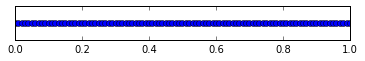

In [49]:
#The one dimensional mesg spanned by piecewise polynomial
mesh = fe.UnitIntervalMesh(Mesh_size) #One Dimensional mesh
P1 = fe.FiniteElement('P', mesh.ufl_cell(), 1)
V = fe.FunctionSpace(mesh, P1)  #Function space spanned by piecewise linear polynomials
v = fe.TestFunction(V)   #Test function
h = fe.Function(V)       #Enthalpy-Trial function
fe.plot(mesh)
plt.show()

Temperature is assumed to be a function of the third power of enthalpy as a guess.

In [50]:
def Temp(h):     #Temperature as a function of enthalpy
	return ((h)**3)   # Approximating the fuction to be cubic such that it closely resemble the physics of the problem
T=Temp(h)

We know that, enthalpy is related to temperature for a phase changing material as,
 
$h = c*T + \phi*L$

$\phi(h)=(h-c*T)/L$

In [51]:
def phis(h):      #Function phi in terms of enthalpy
	return (h-c*T)/L 
phi_h=phis(h)

Since we are solving an initial boundary value problem, and the stefan problem provides the temperature of the two sides of the wall as
  
                      T = 1 ; x = 0   "Hot wall"
   
                      T = -0.01 ; x=1  "Cold wall"
                      
We need to use the function near offered by dolfin to handle inexact arithematic to consider the values in close proximity to the required value.

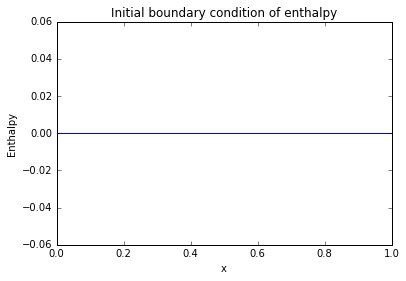

In [52]:
#Setting the boundary conditions to capture the values near the boundary too as we are working in inexact arithmetic.
bc = [fe.DirichletBC(V, fe.Constant(1*c), "near(x[0],  0)"),fe.DirichletBC(V, fe.Constant(-0.01*c), "near(x[0],  1)")]
h_0=fe.Expression('0',degree=0)
h_n = fe.interpolate(h_0, V)
fe.plot(h_n)
plt.title('Initial boundary condition of enthalpy')
plt.xlabel('x')
plt.ylabel('Enthalpy')
plt.show()

Here is where we solve the newton's linearized problem. The variable JF stores the jacobian of the function F with respect to the enthalpy h.

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


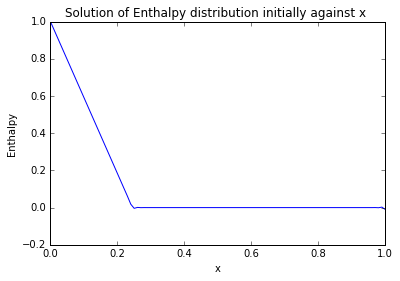

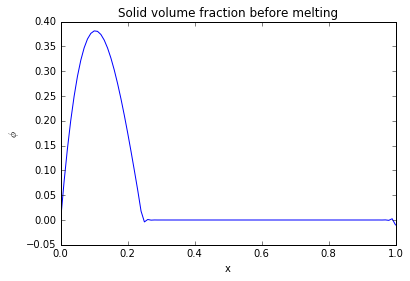

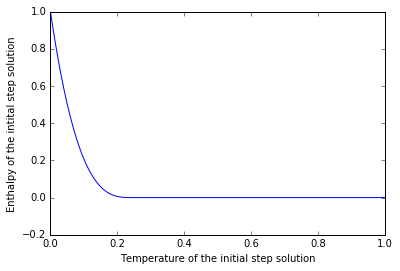

In [53]:
h_t=(h-h_n)/Delta_t#{d\T}/{d\h} Simple gateaux derivative of the c*h^3 function
diffth=(3*(h)**2)                                       #{d\h}/{d\t} but as piecewise as we know the intermediate values 
F=(diffth*(fe.dot(fe.grad(v),fe.grad(h)))+(rho/K)*(h_t*v))*fe.dx    #The nonlinear function to be solved is assembled
JF = fe.derivative(F, h, fe.TrialFunction(V))       #Taking the derivative of the non linear function to solve by newton's method
#Invoking the Newton's method
problem = fe.NonlinearVariationalProblem(F, h, bc, JF)
solver = fe.NonlinearVariationalSolver(problem)
solver.solve()
fe.plot(h)
plt.xlabel('x')
plt.ylabel('Enthalpy')
plt.title('Solution of Enthalpy distribution initially against x ')
plt.show()
fe.plot(phis(h))
plt.xlabel('x')
plt.ylabel('$\phi$')
plt.title('Solid volume fraction before melting')
plt.show()
fe.plot(T,h)
plt.xlabel('Temperature of the initial step solution')
plt.ylabel('Enthalpy of the intital step solution')
plt.show()

Let us consider the time evolution to 5 seconds and concatenate all the values to an vector to be able to visualize the effect.

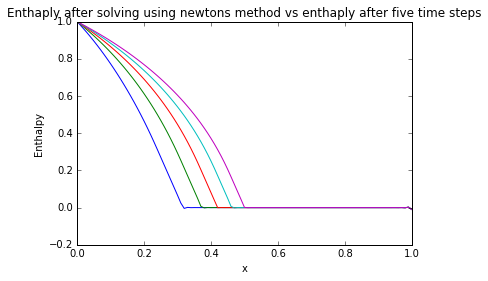

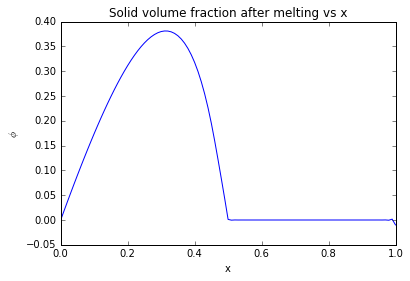

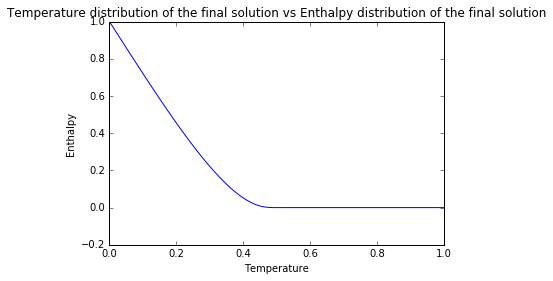

In [54]:
for t in range(5):
    h_n.vector()[:]=h.vector()
    solver.solve()
    fe.plot(h)
plt.xlabel('x')
plt.ylabel('Enthalpy')
plt.title('Enthaply after solving using newton''s method vs enthaply after five time steps')
plt.show()
#Printing and plotting the solution
#fe.plot(T)
#print (h)
plt.title('Solid volume fraction after melting vs x')
plt.xlabel('x')
plt.ylabel('$\phi$')
fe.plot(phis(h))
plt.show()
plt.title('Temperature distribution of the final solution vs Enthalpy distribution of the final solution')
plt.xlabel('Temperature')
plt.ylabel('Enthalpy')
fe.plot(T,h)
plt.show()